#### Import neccesary libraries

In [18]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [19]:
%store -r df
df: pd.DataFrame

### Feature Engineering for training a Random Forest prediction model.

In [20]:
df['Age'] = 2026 - df['Year']
df['Km_per_Year'] = (df['Mileage_km'] / (df['Age'] + 1)).round().astype(int)

#### Classify features by high cardinality, low cardinality, and numeric features.

In [21]:
low_card_feats = ['Fuel_Type', 'Gearbox', 'Condition', 'Body']
high_card_feats = ['Make', 'Model']
numeric_feats = ['Mileage_km', 'Power_hp', 'Age', 'Km_per_Year']

#### Column selection, and dataset split
Some columns were dropped to avoid colinearity, others were dropped to reduce noise caused by non-relevant features. \
**Important**: the Price column was transformed to logarithmic scale, to prevent skewing caused by higher prices on exotic cars.

In [22]:
y = np.log1p(df['Price'])
X = df.drop(columns=['Price', 'Image_url', 'Upholstery', 'Seller', 'Country', 'Year', 'Cylinders', 'Doors', 'Seats', 'Color', 'Non_Smoker_Vehicle']) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      
    random_state=1905  # That's my birthday :)     
)

Numeric features are scaled, One Hot Encoding is applied to low cardinality features, and Ordinal Encoding is applied to those with high cardinality.

In [23]:


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feats),
        ('cat_low', OneHotEncoder(handle_unknown='ignore'), low_card_feats),
        ('cat_high', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_card_feats)
    ]
)

Create pipeline

In [24]:
model_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

model_pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_low', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
y_pred = model_pipeline.predict(X_test)

## Performance Metrics

R² score

In [26]:
from sklearn.metrics import r2_score


r2 = r2_score(y_test, y_pred)

print(f"R² in testing: {r2:.4f}")

R² in testing: 0.9411


Mean Average Error \
Before this, the price column is reverted from logarithmic scale back to euros.

In [27]:
from sklearn.metrics import mean_absolute_error

y_pred_log = model_pipeline.predict(X_test)

y_pred_usd = np.exp(y_pred_log)
y_test_usd = np.exp(y_test)

mae_final = mean_absolute_error(y_test_usd, y_pred_usd)
print(f"Mean average error: {mae_final:.2f} €")

Mean average error: 12574.65 €


The MAE may seem high, but this can be caused by higher prices on exotic cars, where the error is expected to be high, thus increasing the mean.\
The way to go is to calculate the mean average **percentage** error: 

In [28]:
mape = np.mean(np.abs((y_test_usd - y_pred_usd) / y_test_usd)) * 100
print(f"Mean average percentage error: {mape:.2f}%")

Mean average percentage error: 17.70%


Plot the model's performance.

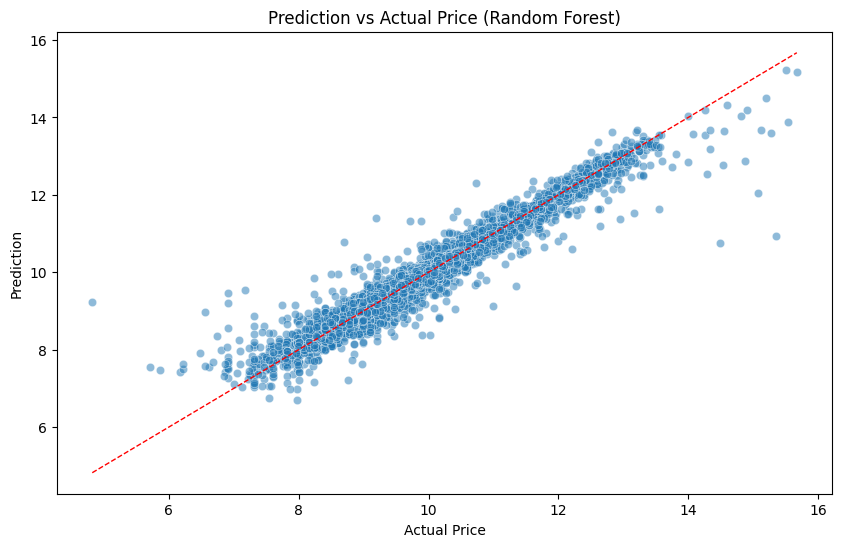

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1)
plt.xlabel('Actual Price')
plt.ylabel('Prediction')
plt.title('Prediction vs Actual Price (Random Forest)')
plt.show()

In [30]:
filename = '../models/model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_pipeline, file)